In [1]:
import os
import time
import random
import datetime

import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
slim = tf.contrib.slim

# Training

In [2]:
mnist = input_data.read_data_sets('MNIST_data')
x_size, y_size = 28, 28
n_classes = 10

n_epochs = 1000
ckpt_path = 'models/MNIST_NLA_method1.ckpt'
variables_file = './variables/scheme1_fr.npz'
activations_file = './variables/scheme1_dr.npz'

def timestamp():
    d = datetime.datetime.now()
    return d.strftime("%Y/%m/%d/%X")

timestamp()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


'2016/12/15/21:22:37'

In [3]:
def random_batch_iterator(x, y, *, batch_size):
    n = x.shape[0]
    assert n == y.shape[0]
    
    while True:
        index = np.random.randint(n, size=batch_size)
        x_batch, y_batch = x[index], y[index]
        yield x_batch.copy(), y_batch.copy()
        
def batch_iterator(x, y, batch_size):
    n = x.shape[0]
    assert n == y.shape[0]
    
    for i in range(0, n, batch_size):
        x_batch, y_batch = x[i:i+batch_size], y[i:i+batch_size]        
        yield x_batch.copy(), y_batch.copy()

In [7]:
batch_size = 1024
test_list = list(batch_iterator(
        mnist.test.images, mnist.test.labels, batch_size=batch_size))

n_conv = 2
conv_base = 32
conv_mul = 2
conv_size = 5
pool_size = 2

def build_model(graph, build_cnn):
    with graph.as_default():#, graph.device('/cpu:0'):
        with tf.variable_scope('model') as vs:
            is_training = tf.placeholder(tf.bool)
            x_ph = tf.placeholder(tf.float32, shape=[batch_size, x_size * y_size])
            x_image = tf.reshape(x_ph, [-1, x_size, y_size, 1])
            y_ph = tf.placeholder(tf.int64, shape=[batch_size])

            logits = build_cnn(x_image, is_training=is_training, n_conv=n_conv,
                               conv_base=conv_base, conv_mul=conv_mul,
                               conv_size=conv_size, pool_size=pool_size)

            prediction = tf.nn.softmax(logits, name='predictions')

            loss = build_loss(logits, y_ph)

            optimizer = tf.train.AdamOptimizer().minimize(loss, name='optimizer')

            correct_prediction = tf.equal(tf.argmax(prediction, 1), y_ph)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

        # Code to use of tensorboard
        with tf.name_scope('summaries'):
            tf.scalar_summary('log_loss', loss)
            tf.scalar_summary('acc', accuracy)
            merged_summary = tf.merge_all_summaries()
            
    return {
        'is_training': is_training,
        'x_ph': x_ph,
        'y_ph': y_ph,
        'prediction': prediction,
        'loss': loss,
        'optimizer': optimizer,
        'accuracy': accuracy,
        'merged_summary': merged_summary
    }

In [8]:
def train_net(layers, session, *, ckpt_path, n_epochs, tb_path='/tmp/tf/'):
    tb_path = tb_path + timestamp()
    
    l = layers
    x_ph, y_ph, is_training = l['x_ph'], l['y_ph'], l['is_training']
    val_operations = [l['merged_summary'], l['accuracy'], l['loss']]
    train_operations = [l['optimizer']] + val_operations

    train_iterator = random_batch_iterator(
        mnist.train.images, mnist.train.labels, batch_size=batch_size)
    val_iterator = random_batch_iterator(
        mnist.validation.images, mnist.validation.labels, batch_size=batch_size)
        
    train_writer = tf.train.SummaryWriter(tb_path+'/train', session.graph)
    val_writer = tf.train.SummaryWriter(tb_path+'/val', session.graph)
    saver = tf.train.Saver()

    best_acc = 0.0
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        x_batch, y_batch = next(train_iterator)
        feed_dict = {x_ph: x_batch, y_ph: y_batch, is_training: True}
        _, summary, acc, _ = session.run(train_operations, feed_dict)
        train_writer.add_summary(summary, epoch)

        x_batch, y_batch = next(val_iterator)
        feed_dict = {x_ph: x_batch, y_ph: y_batch, is_training: False}
        summary, acc, _ = session.run(val_operations, feed_dict)
        val_writer.add_summary(summary, epoch)

    saver.save(session, ckpt_path)
                
    return best_acc

def evaluate_net(layers, session):
    l = layers
    x_ph, y_ph, is_training = l['x_ph'], l['y_ph'], l['is_training']
    
    test_iterator = iter(test_list)
    
    n, test_acc = 0, 0.0
    start = time.time()
    for x_batch, y_batch in test_iterator:
        if len(x_batch) != batch_size:
            break
        feed_dict = {x_ph: x_batch, y_ph: y_batch, is_training: False}
        test_acc += l['accuracy'].eval(feed_dict=feed_dict)
        n += 1
    end = time.time()
    test_acc = test_acc / n
    return test_acc, end-start

In [9]:
def build_cnn_method1(inputs, *, is_training, n_conv, conv_base, conv_mul,
              conv_size, pool_size):
    l = inputs
    
    for i in range(n_conv):
        n_filters = conv_base * conv_mul ** i
        M = n_filters // 2
        
        batch_size, w, h, in_channels = l.get_shape()
        with tf.variable_scope('conv{}'.format(i+1)):
            f = tf.get_variable('basis', shape=[conv_size, conv_size, in_channels, M])
            l = tf.nn.depthwise_conv2d(l, f, [1, 1, 1, 1], padding='SAME', name='conv')
            l = slim.conv2d(l, n_filters,kernel_size=[1, 1], padding='SAME',
                            scope='a'.format(i+1))
        l = slim.max_pool2d(l, [pool_size, pool_size], scope='maxpool{}'.format(i+1))
    l = slim.flatten(l)
    
    l = slim.dropout(l, 0.5, scope='dropout', is_training=is_training)
    l = slim.fully_connected(l, 10, activation_fn=None, scope='logits')
    return l

def build_loss(logits, y_true):
    logloss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_true),
                             name='logloss')
    return logloss

In [10]:
graph = tf.Graph()
layers = build_model(graph, build_cnn_method1)
with tf.Session(graph=graph) as session:
    train_net(layers, session, n_epochs=n_epochs, ckpt_path=ckpt_path)
    test_acc, els = evaluate_net(layers, session)

test_acc, els

KeyboardInterrupt: 

In [10]:
n_measurements = 100

with tf.Session(graph=graph) as session:
    restorer = tf.train.Saver()
    restorer.restore(session, tf.train.latest_checkpoint(ckpt_dir))
    mesurements = []
    for i in range(n_measurements):
        test_acc, els = evaluate_net(layers, session)
        mesurements.append(els)

KeyboardInterrupt: 

(array([  2.,   0.,   1.,   0.,   2.,   4.,   6.,   4.,   7.,   6.,   6.,
          8.,  11.,   8.,   9.,  11.,   9.,   2.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.14   ,  0.14025,  0.1405 ,  0.14075,  0.141  ,  0.14125,
         0.1415 ,  0.14175,  0.142  ,  0.14225,  0.1425 ,  0.14275,
         0.143  ,  0.14325,  0.1435 ,  0.14375,  0.144  ,  0.14425,
         0.1445 ,  0.14475,  0.145  ,  0.14525,  0.1455 ,  0.14575,
         0.146  ,  0.14625,  0.1465 ,  0.14675,  0.147  ,  0.14725,
         0.1475 ,  0.14775,  0.148  ,  0.14825,  0.1485 ,  0.14875,
         0.149  ,  0.14925,  0.1495 ,  0.14975,  0.15   ]),
 <a list of 40 Patch objects>)

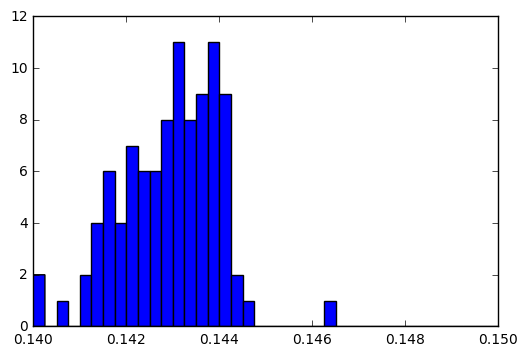

In [11]:
plt.hist(mesurements, bins=40, range=(0.14, 0.15))